In [1]:
# import sys
# !{sys.executable} -m pip install tabulate
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
import janitor
import tabulate
from tqdm import tqdm
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
print(tf.__version__)

2.7.0


In [28]:
# set definitions
glacier = gl.data_loader(pth = '/data/fast1/glacierml/T_models/')
# ,TT,TTT,TTTx,TTT_full
# T_t = T.head()
gl.thickness_renamer(glacier)
(train_features, test_features, train_labels, test_labels) = gl.data_splitter(glacier)
LR = np.logspace(-3,2,6)
vs = 0.2
VS = 0.1,0.15,0.2,0.25,0.3,0.35,0.4
RS = range(0,25,1)
ep = 300

glacier.name = 'glacier'
# T_t.name = 'T_t'
# TT.name = 'band'
# TTT.name = 'point'
# TTTx.name = 'TTTx'
# TTT_full.name = 'TTT_full'
arch = '16-8'
pth_mod = 'sm/sm_' + arch + '/'
pth_res = 'sr/sr_' + arch + '/'

Importing data...
Importing T database
Import complete


Results compiled


/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

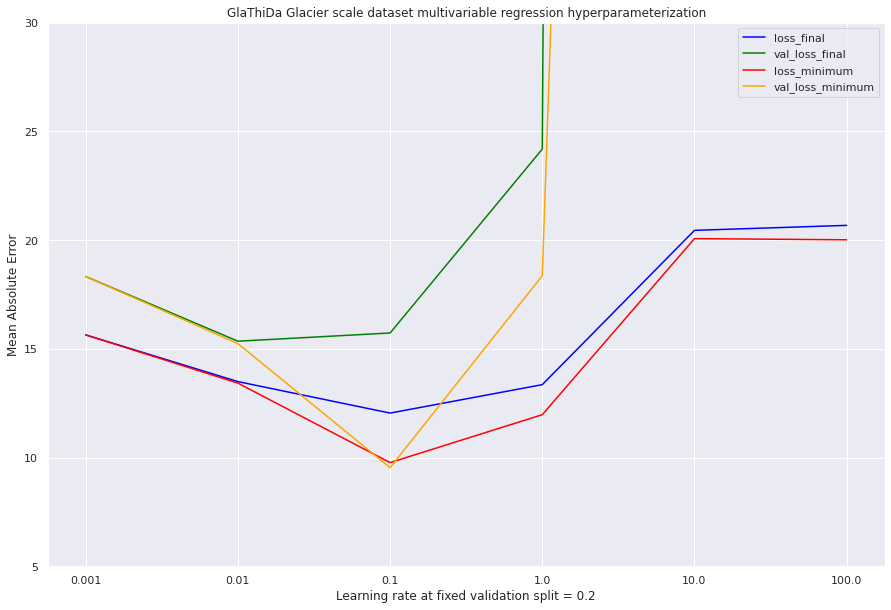

Results compiled


/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

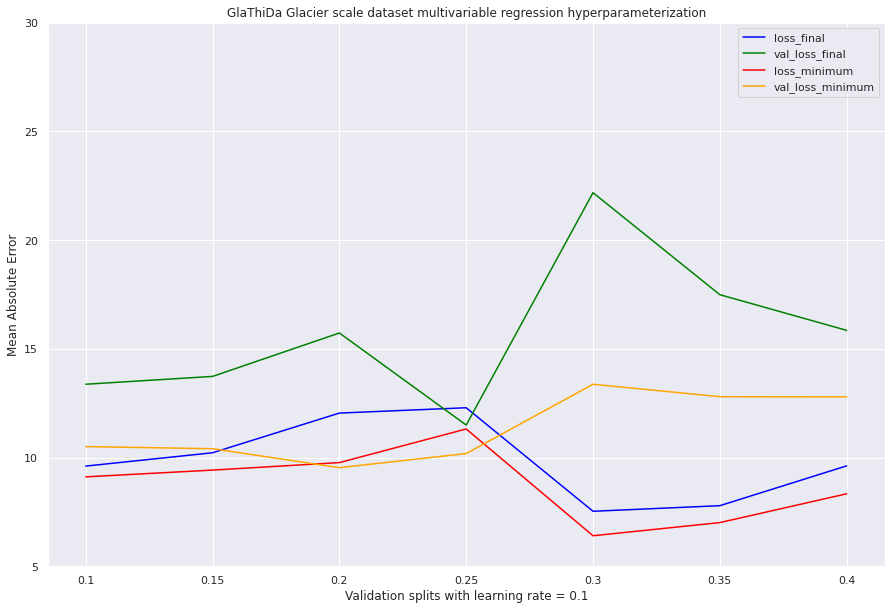

<Figure size 1080x720 with 0 Axes>

In [4]:
loss = {}
dnn_lr_history = {}
loss['glacier_min_learn'] = pd.DataFrame()
loss['glacier_fin_learn'] = pd.DataFrame()
for lr in LR:
    file_name = (
    'sr/sr_64/'
    + 'glacier_dnn_history_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    file = (
    'glacier_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    
    
    dnn_lr_history[
    'glacier_MULTI_' 
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep)
    ] = pd.read_csv(file_name)
    
    
    m_loss = dnn_lr_history[file].min()
    m_loss['learning rate'] = str(lr)
    m_loss['validation split'] = str(vs)
    m_loss['epochs'] = str(ep)
    loss['glacier_min_learn'] = loss['glacier_min_learn'].append(m_loss,ignore_index=True)

    f = dnn_lr_history[file].last_valid_index()
    f_loss = dnn_lr_history[file].iloc[[f]]
    f_loss['learning rate'] = str(lr)
    f_loss['validation split'] = str(vs)
    f_loss['epochs'] = str(ep)

    loss['glacier_fin_learn'] = loss['glacier_fin_learn'].append(f_loss,ignore_index=True)

# loss['glacier_fin_learn'] = loss['glacier_fin_learn'].drop('Unnamed: 0',axis=1)
loss['glacier_fin_learn'] = loss['glacier_fin_learn'].rename(columns = {
    'loss':'loss_final',
    'val_loss':'val_loss_final'
})

# loss['glacier_min_learn'] = loss['glacier_min_learn'].drop('Unnamed: 0',axis=1)
loss['glacier_min_learn'] = loss['glacier_min_learn'].rename(columns = {
    'loss':'loss_minimum',
    'val_loss':'val_loss_minimum'
})
    
print('Results compiled')
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([5,30])
# loss['glacier_min'].plot(x='validation split', y = ['loss_minimum', 'val_loss_minimum'], kind='bar',  ax=ax)
# loss['glacier_fin'].plot(x='validation split', y = ['loss_final', 'val_loss_final'], kind='bar',  ax=ax)

loss['glacier_fin_learn'].plot(x='learning rate', y = 'loss_final',color = 'blue',  ax=ax)
loss['glacier_fin_learn'].plot(x='learning rate', y = 'val_loss_final',color = 'green', ax=ax)
loss['glacier_min_learn'].plot(x='learning rate', y = 'loss_minimum', color = 'red', ax=ax)
loss['glacier_min_learn'].plot(x='learning rate', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Learning rate at fixed validation split = 0.2')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression hyperparameterization')
plt.show()
plt.tight_layout()

lr = 0.1
loss = {}
dnn_vs_history = {}
loss['glacier_min_valsplit'] = pd.DataFrame()
loss['glacier_fin_valsplit'] = pd.DataFrame()
for vs in VS:
    file_name = (
    'sr/sr_64/'
    + 'glacier_dnn_history_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    file = (
    'glacier_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    
    
    dnn_lr_history[
    'glacier_MULTI_' 
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep)
    ] = pd.read_csv(file_name)
    
    
    m_loss = dnn_lr_history[file].min()
    m_loss['learning rate'] = str(lr)
    m_loss['validation split'] = str(vs)
    m_loss['epochs'] = str(ep)
    loss['glacier_min_valsplit'] = loss['glacier_min_valsplit'].append(m_loss,ignore_index=True)

    f = dnn_lr_history[file].last_valid_index()
    f_loss = dnn_lr_history[file].iloc[[f]]
    f_loss['learning rate'] = str(lr)
    f_loss['validation split'] = str(vs)
    f_loss['epochs'] = str(ep)

    loss['glacier_fin_valsplit'] = loss['glacier_fin_valsplit'].append(f_loss,ignore_index=True)

# loss['glacier_fin_learn'] = loss['glacier_fin_learn'].drop('Unnamed: 0',axis=1)
loss['glacier_fin_valsplit'] = loss['glacier_fin_valsplit'].rename(columns = {
    'loss':'loss_final',
    'val_loss':'val_loss_final'
})

# loss['glacier_min_learn'] = loss['glacier_min_learn'].drop('Unnamed: 0',axis=1)
loss['glacier_min_valsplit'] = loss['glacier_min_valsplit'].rename(columns = {
    'loss':'loss_minimum',
    'val_loss':'val_loss_minimum'
})
    
print('Results compiled')
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([5,30])
# loss['glacier_min'].plot(x='validation split', y = ['loss_minimum', 'val_loss_minimum'], kind='bar',  ax=ax)
# loss['glacier_fin'].plot(x='validation split', y = ['loss_final', 'val_loss_final'], kind='bar',  ax=ax)

loss['glacier_fin_valsplit'].plot(x='validation split', y = 'loss_final',color = 'blue',  ax=ax)
loss['glacier_fin_valsplit'].plot(x='validation split', y = 'val_loss_final',color = 'green', ax=ax)
loss['glacier_min_valsplit'].plot(x='validation split', y = 'loss_minimum', color = 'red', ax=ax)
loss['glacier_min_valsplit'].plot(x='validation split', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Validation splits with learning rate = 0.1')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression hyperparameterization')
plt.show()
plt.tight_layout()

In [5]:
lr = 0.1
vs = 0.2
# load models
print('Loading models....')

linear_model = {}
dnn_model = {}
(train_features, test_features, train_labels, test_labels) = gl.data_splitter(glacier)
for variable_name in tqdm(list(train_features) + ['MULTI']):
    for rs in RS:
        file_name = (
        pth_mod 
        + 'glacier' 
        + '_linear_' 
        + variable_name 
        + '_' 
        + str(lr)
        + '_'
        + str(vs)
        + '_'
        + str(ep)
        + '_'
        + str(rs)
        )

        linear_model[
            'glacier' 
            + '_' 
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            + '_'
            + str(rs)
        ] = tf.keras.models.load_model(file_name)
        
for variable_name in tqdm(list(train_features) + ['MULTI']):
    for rs in RS:
        file_name = (
        pth_mod 
        + 'glacier' 
        + '_dnn_' 
        + variable_name 
        + '_' 
        + str(lr)
        + '_'
        + str(vs)
        + '_'
        + str(ep)
        + '_'
        + str(rs)
        )

        dnn_model[
            'glacier'
            + '_' 
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            + '_'
            + str(rs)
        ] = tf.keras.models.load_model(file_name)
print('Models loaded')

# load all histories
print('Loading histories....')
linear_history = {}
dnn_history = {}
for variable_name in tqdm(list(train_features) + ['MULTI']):
    for rs in RS:
        file_name = (
            pth_res 
            + 'glacier' 
            +'_linear_history_'
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            + '_'
            + str(rs)
        )

        linear_history[
            'glacier' 
            +'_'
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            + '_'
            + str(rs)
        ]= pd.read_csv(file_name)

for variable_name in tqdm(list(train_features) + ['MULTI']):
    for rs in RS:
        file_name = (
            pth_res 
            + 'glacier_dnn_history_' 
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            + '_'
            + str(rs)
        )

        dnn_history[
            'glacier' 
            +'_'
            + variable_name 
            + '_' 
            + str(lr)
            + '_'
            + str(vs)
            + '_'
            + str(ep)
            + '_'
            + str(rs)
        ] = pd.read_csv(file_name)
print('Histories loaded')

Loading models....


100%|██████████| 5/5 [00:22<00:00,  4.55s/it]


Models loaded
Loading histories....


100%|██████████| 5/5 [00:00<00:00, 42.97it/s]

Histories loaded


In [27]:
rootdir = 'sm/'
ext = ('.csv')
# print(rootdir)
for subdir, dirs, files in tqdm(os.walk(rootdir, topdown=True)):
    print(subdir)
#     for dirs in os.walk(subdir):
#         print(dirs)
#     layers = subdir[6:]
#     print(layers)
    
#     print(layers)
#     if '/variables' in layers:
#         print(layers)
#         loss[layers] = pd.DataFrame()
#         for d in dirs:
#             print(str(d))
#             loss[layers] = pd.DataFrame()
#             file_reader = pd.read_csv(rootdir + 'sr_' + str(layers) +'/'+ file)
#             loss[layers] = loss[layers].append(file_reader) 
                            
#     for rs in RS:
#         file_name = (
#         pth_mod 
#         + 'glacier' 
#         + '_dnn_' 
#         + variable_name 
#         + '_' 
#         + str(lr)
#         + '_'
#         + str(vs)
#         + '_'
#         + str(ep)
#         + '_'
#         + str(rs)
#         )

2726it [00:00, 13630.92it/s]

sm/
sm/sm_12-6-3
sm/sm_12-6-3/glacier_linear_lat_0.1_0.2_300_0
sm/sm_12-6-3/glacier_linear_lat_0.1_0.2_300_0/variables
sm/sm_12-6-3/glacier_linear_lat_0.1_0.2_300_0/assets
sm/sm_12-6-3/glacier_linear_lon_0.1_0.2_300_0
sm/sm_12-6-3/glacier_linear_lon_0.1_0.2_300_0/variables
sm/sm_12-6-3/glacier_linear_lon_0.1_0.2_300_0/assets
sm/sm_12-6-3/glacier_linear_area_0.1_0.2_300_0
sm/sm_12-6-3/glacier_linear_area_0.1_0.2_300_0/variables
sm/sm_12-6-3/glacier_linear_area_0.1_0.2_300_0/assets
sm/sm_12-6-3/glacier_linear_mean_slope_0.1_0.2_300_0
sm/sm_12-6-3/glacier_linear_mean_slope_0.1_0.2_300_0/variables
sm/sm_12-6-3/glacier_linear_mean_slope_0.1_0.2_300_0/assets
sm/sm_12-6-3/glacier_linear_MULTI_0.1_0.2_300_0
sm/sm_12-6-3/glacier_linear_MULTI_0.1_0.2_300_0/variables
sm/sm_12-6-3/glacier_linear_MULTI_0.1_0.2_300_0/assets
sm/sm_12-6-3/glacier_dnn_lat_0.1_0.2_300_0
sm/sm_12-6-3/glacier_dnn_lat_0.1_0.2_300_0/variables
sm/sm_12-6-3/glacier_dnn_lat_0.1_0.2_300_0/assets
sm/sm_12-6-3/glacier_dnn_lon_0.1

5452it [00:00, 13614.28it/s]

sm/sm_6-4-2/glacier_dnn_area_0.1_0.2_300_3
sm/sm_6-4-2/glacier_dnn_area_0.1_0.2_300_3/variables
sm/sm_6-4-2/glacier_dnn_area_0.1_0.2_300_3/assets
sm/sm_6-4-2/glacier_dnn_mean_slope_0.1_0.2_300_3
sm/sm_6-4-2/glacier_dnn_mean_slope_0.1_0.2_300_3/variables
sm/sm_6-4-2/glacier_dnn_mean_slope_0.1_0.2_300_3/assets
sm/sm_6-4-2/glacier_dnn_MULTI_0.1_0.2_300_3
sm/sm_6-4-2/glacier_dnn_MULTI_0.1_0.2_300_3/variables
sm/sm_6-4-2/glacier_dnn_MULTI_0.1_0.2_300_3/assets
sm/sm_6-4-2/glacier_linear_lat_0.1_0.2_300_4
sm/sm_6-4-2/glacier_linear_lat_0.1_0.2_300_4/variables
sm/sm_6-4-2/glacier_linear_lat_0.1_0.2_300_4/assets
sm/sm_6-4-2/glacier_linear_lon_0.1_0.2_300_4
sm/sm_6-4-2/glacier_linear_lon_0.1_0.2_300_4/variables
sm/sm_6-4-2/glacier_linear_lon_0.1_0.2_300_4/assets
sm/sm_6-4-2/glacier_linear_area_0.1_0.2_300_4
sm/sm_6-4-2/glacier_linear_area_0.1_0.2_300_4/variables
sm/sm_6-4-2/glacier_linear_area_0.1_0.2_300_4/assets
sm/sm_6-4-2/glacier_linear_mean_slope_0.1_0.2_300_4
sm/sm_6-4-2/glacier_linear_mea

7120it [00:00, 13571.95it/s]

sm/sm_8-4/glacier_dnn_mean_slope_0.1_0.2_300_19/variables
sm/sm_8-4/glacier_dnn_mean_slope_0.1_0.2_300_19/assets
sm/sm_8-4/glacier_dnn_MULTI_0.1_0.2_300_19
sm/sm_8-4/glacier_dnn_MULTI_0.1_0.2_300_19/variables
sm/sm_8-4/glacier_dnn_MULTI_0.1_0.2_300_19/assets
sm/sm_8-4/glacier_linear_lat_0.1_0.2_300_20
sm/sm_8-4/glacier_linear_lat_0.1_0.2_300_20/variables
sm/sm_8-4/glacier_linear_lat_0.1_0.2_300_20/assets
sm/sm_8-4/glacier_linear_lon_0.1_0.2_300_20
sm/sm_8-4/glacier_linear_lon_0.1_0.2_300_20/variables
sm/sm_8-4/glacier_linear_lon_0.1_0.2_300_20/assets
sm/sm_8-4/glacier_linear_area_0.1_0.2_300_20
sm/sm_8-4/glacier_linear_area_0.1_0.2_300_20/variables
sm/sm_8-4/glacier_linear_area_0.1_0.2_300_20/assets
sm/sm_8-4/glacier_linear_mean_slope_0.1_0.2_300_20
sm/sm_8-4/glacier_linear_mean_slope_0.1_0.2_300_20/variables
sm/sm_8-4/glacier_linear_mean_slope_0.1_0.2_300_20/assets
sm/sm_8-4/glacier_linear_MULTI_0.1_0.2_300_20
sm/sm_8-4/glacier_linear_MULTI_0.1_0.2_300_20/variables
sm/sm_8-4/glacier_l

In [7]:
pth = '/data/fast1/glacierml/T_models/'
T_lab = pd.read_csv(pth + 'T.csv', low_memory = False)
T_lab = T_lab[[
    'GlaThiDa_ID',
    'LAT',
    'LON',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS'
]]
T_lab = T_lab.dropna()

tru_thickness = np.sum(T_lab['MEAN_THICKNESS']) / len(T_lab['MEAN_THICKNESS'])
tru_thickness

50.45945945945946

In [8]:
loss

{'glacier_min_valsplit':    Unnamed: 0  loss_minimum  val_loss_minimum learning rate validation split  \
 0         0.0      9.113214         10.505543           0.1              0.1   
 1         0.0      9.424646         10.407511           0.1             0.15   
 2         0.0      9.769318          9.535880           0.1              0.2   
 3         0.0     11.316066         10.185942           0.1             0.25   
 4         0.0      6.404987         13.372907           0.1              0.3   
 5         0.0      7.009769         12.799928           0.1             0.35   
 6         0.0      8.334406         12.792502           0.1              0.4   
 
   epochs  
 0    300  
 1    300  
 2    300  
 3    300  
 4    300  
 5    300  
 6    300  ,
 'glacier_fin_valsplit':    Unnamed: 0  loss_final  val_loss_final learning rate validation split  \
 0         299    9.608909       13.373328           0.1              0.1   
 1         299   10.221459       13.732797         

In [29]:
prethicktions = pd.DataFrame()
for rs in RS:
    file = (
    'glacier'
    +'_'
    + 'MULTI'
    + '_' 
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep)
    + '_'
    + str(rs))
    
    mae = dnn_model['glacier_MULTI_0.1_0.2_300_' + str(rs)].evaluate(test_features,
                                                      test_labels,
                                                      verbose=0)
    pred_train = dnn_model[file].predict(train_features)
    pred_test = dnn_model[file].predict(test_features)
    y = np.concatenate([pred_train,pred_test])
    avg_thickness = pd.Series((np.sum(y) / len(y)), name = 'avg thickness')
    prethicktions = prethicktions.append(avg_thickness, ignore_index=True)
    prethicktions.loc[prethicktions.index[-1], 'model']= file
    prethicktions.loc[prethicktions.index[-1], 'mean absolute error']= mae
#     prethicktions.loc[prethicktions.index[-1], 'architecture']= pth_res[3:] 

prethicktions.rename(columns = {0:'avg thickness'},inplace = True)    
print(prethicktions.to_markdown())

|    |   avg thickness | model                        |   mean absolute error |
|---:|----------------:|:-----------------------------|----------------------:|
|  0 |         70.6086 | glacier_MULTI_0.1_0.2_300_0  |              135.144  |
|  1 |         52.3222 | glacier_MULTI_0.1_0.2_300_1  |               43.0096 |
|  2 |         48.4307 | glacier_MULTI_0.1_0.2_300_2  |               21.0505 |
|  3 |         54.9057 | glacier_MULTI_0.1_0.2_300_3  |               32.2229 |
|  4 |         47.8686 | glacier_MULTI_0.1_0.2_300_4  |               26.581  |
|  5 |         52.4438 | glacier_MULTI_0.1_0.2_300_5  |               36.4699 |
|  6 |         49.4679 | glacier_MULTI_0.1_0.2_300_6  |               35.3918 |
|  7 |         55.8282 | glacier_MULTI_0.1_0.2_300_7  |               37.1448 |
|  8 |         48.6766 | glacier_MULTI_0.1_0.2_300_8  |               25.3194 |
|  9 |         54.7435 | glacier_MULTI_0.1_0.2_300_9  |               24.3646 |
| 10 |         47.3728 | glacier_MULTI_0

In [10]:
# compute standard deviations

mae_mean = np.sum(prethicktions['mean absolute error']) / len(prethicktions)
diff_sq = pd.Series()
for mae in prethicktions['mean absolute error']:
    step_2 = pd.Series((mae - mae_mean)**2)
    diff_sq = diff_sq.append(step_2, ignore_index=True)
mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
mae_std_dev = np.sqrt(mean_diff_sq)
print('avg mae')
print(mae_mean)
print('')
print('std dev of mae')
print(mae_std_dev)
print('')

thickness_mean = np.sum(prethicktions['avg thickness']) / len(prethicktions)
diff_sq = pd.Series()
for thickness in prethicktions['avg thickness']:
    step_2 = pd.Series((thickness - thickness_mean)**2)
    diff_sq = diff_sq.append(step_2, ignore_index=True)
mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
thickness_std_dev = np.sqrt(mean_diff_sq)
print('std dev of prethicktions')
print(thickness_std_dev)

avg mae
43.57786956787109

std dev of mae
31.413210044391928

std dev of prethicktions
6.938567981372216


(array([1., 0., 4., 4., 7., 5., 1., 1., 0., 2.]),
 array([38.32448065, 41.55289284, 44.78130504, 48.00971724, 51.23812944,
        54.46654164, 57.69495384, 60.92336603, 64.15177823, 67.38019043,
        70.60860263]),
 <BarContainer object of 10 artists>)

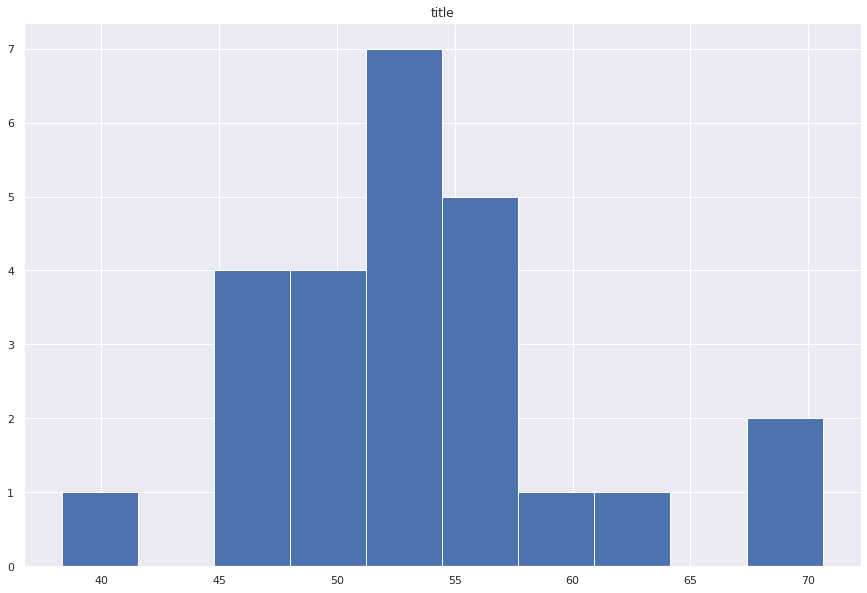

In [11]:
fig,ax = plt.subplots()
ax.set_title('title')
fig.patch.set_facecolor('w')
plt.hist(prethicktions['avg thickness'])

In [12]:
# ccccombo_breaker()

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


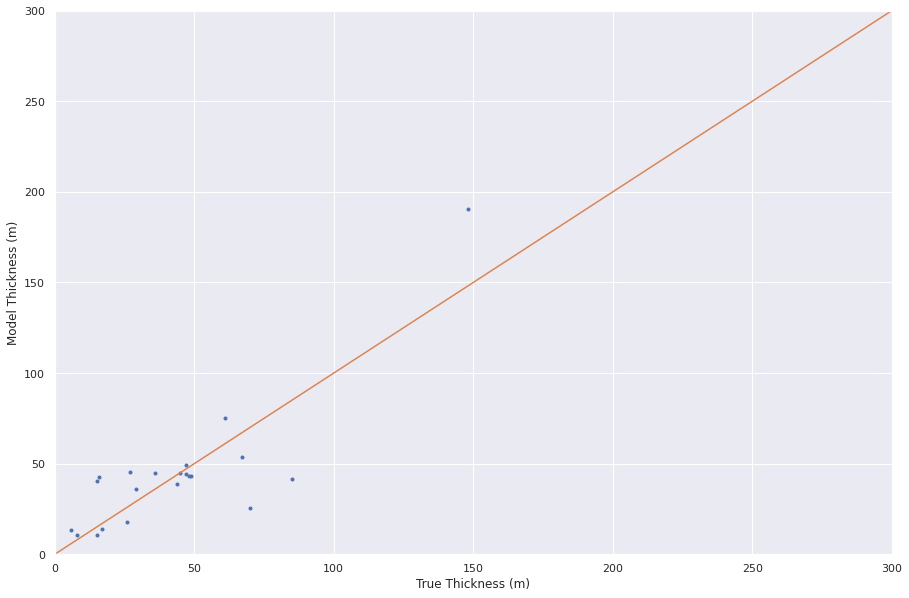

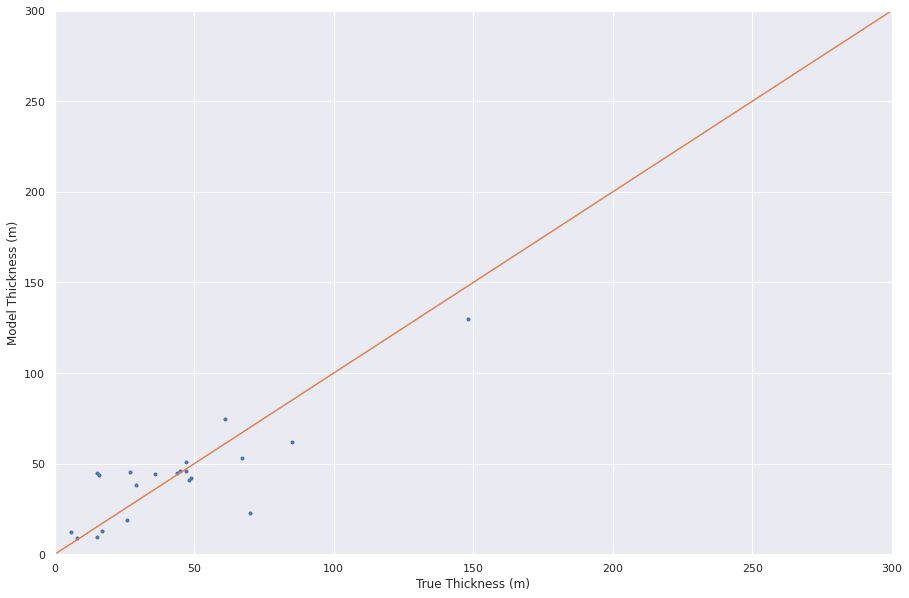

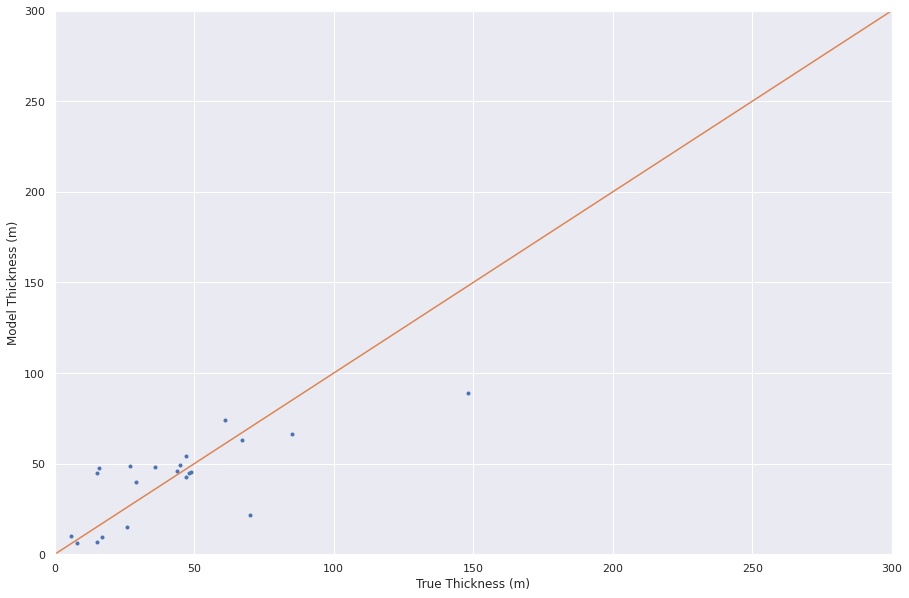

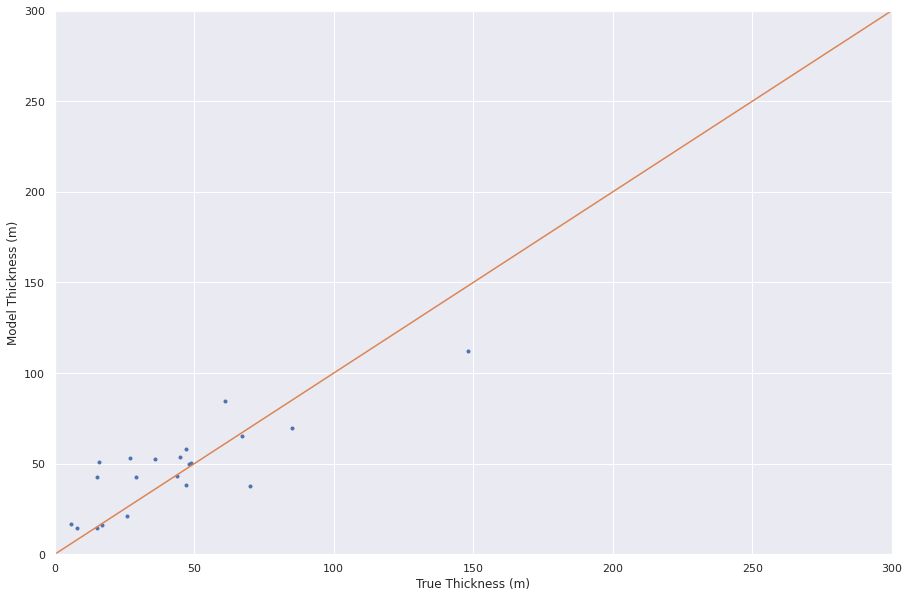

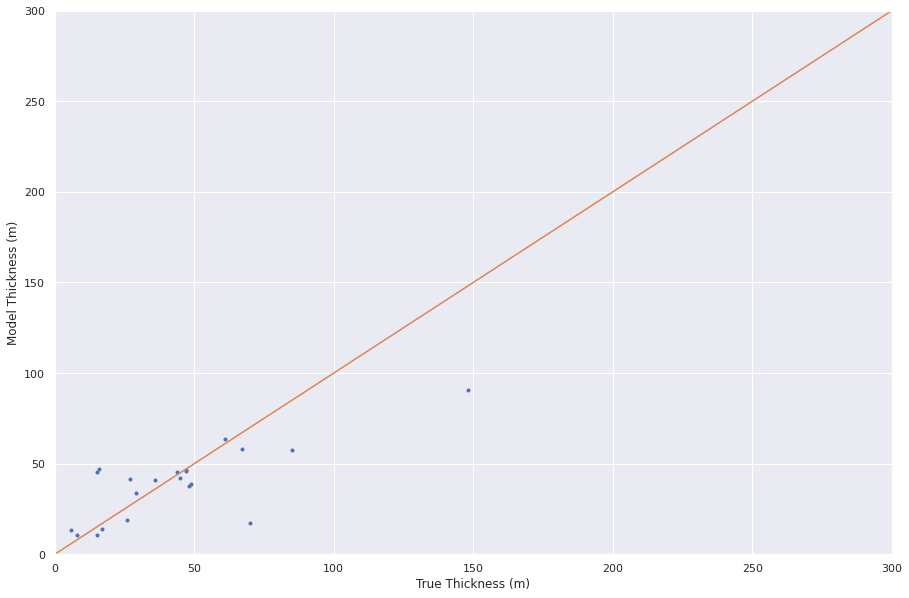

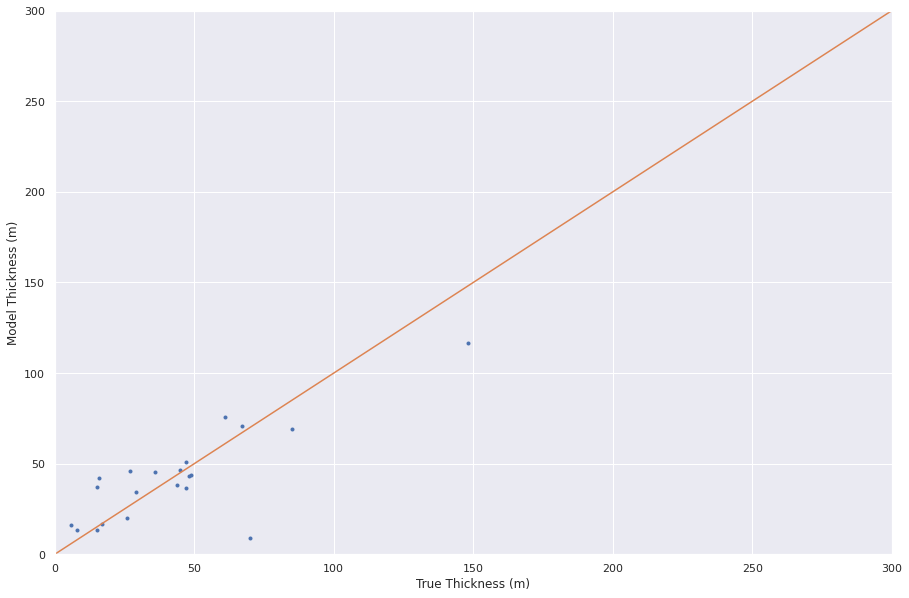

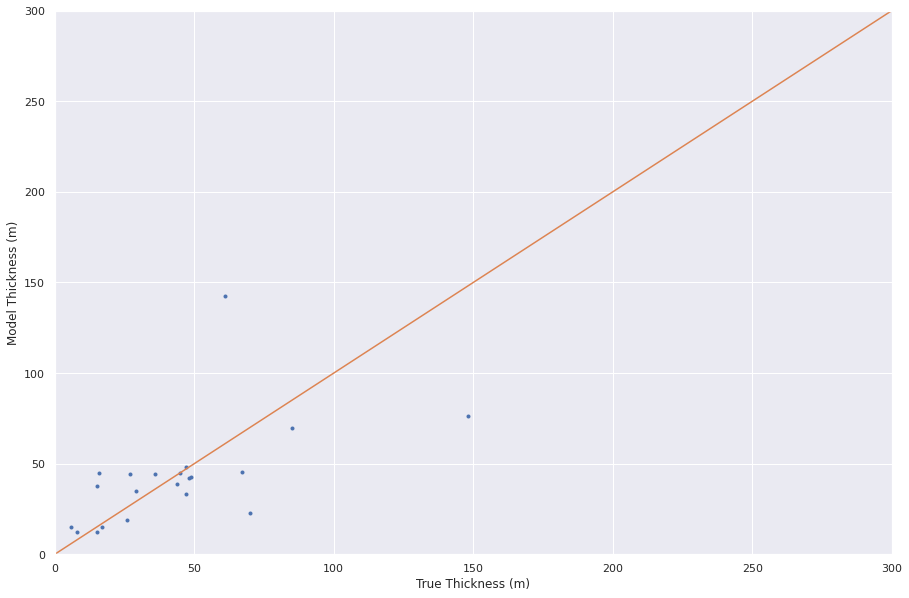

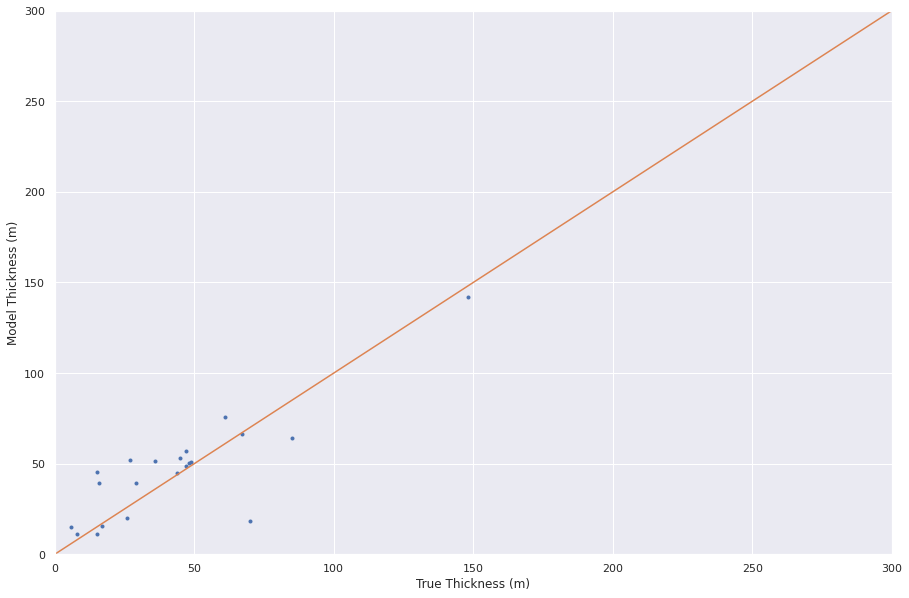

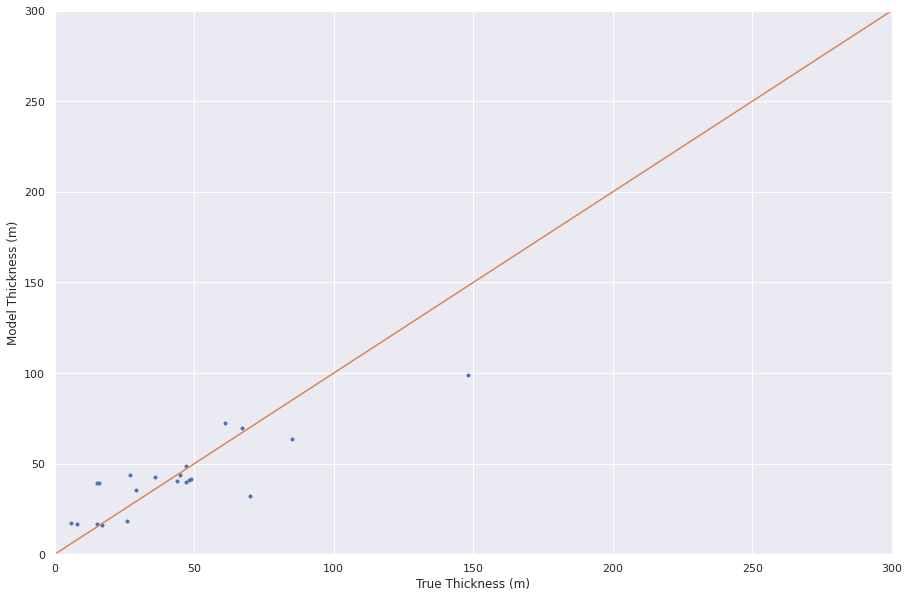

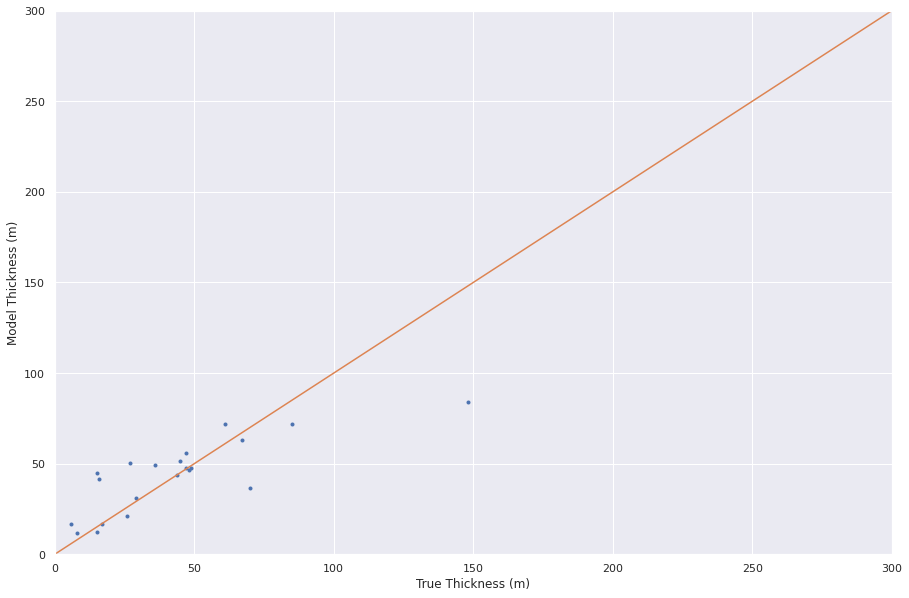

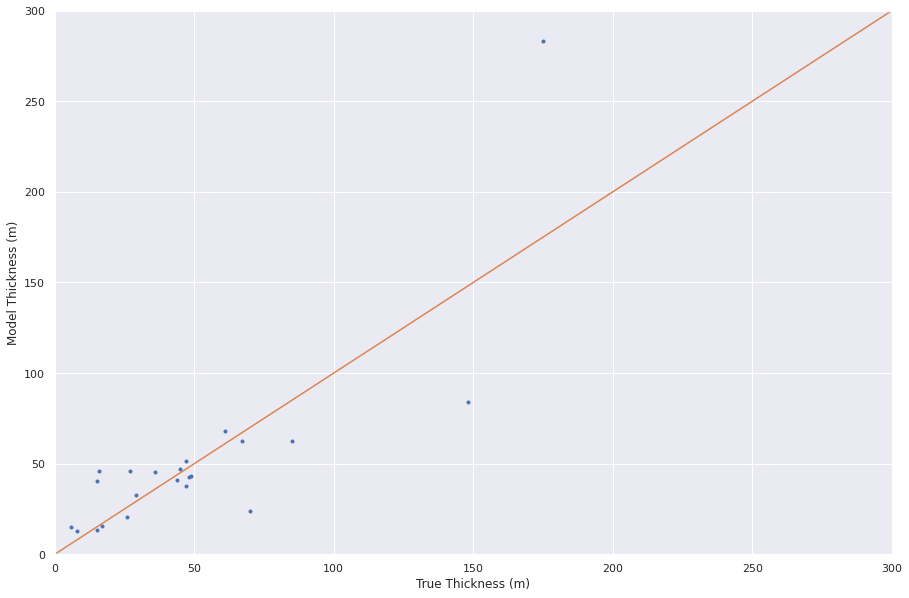

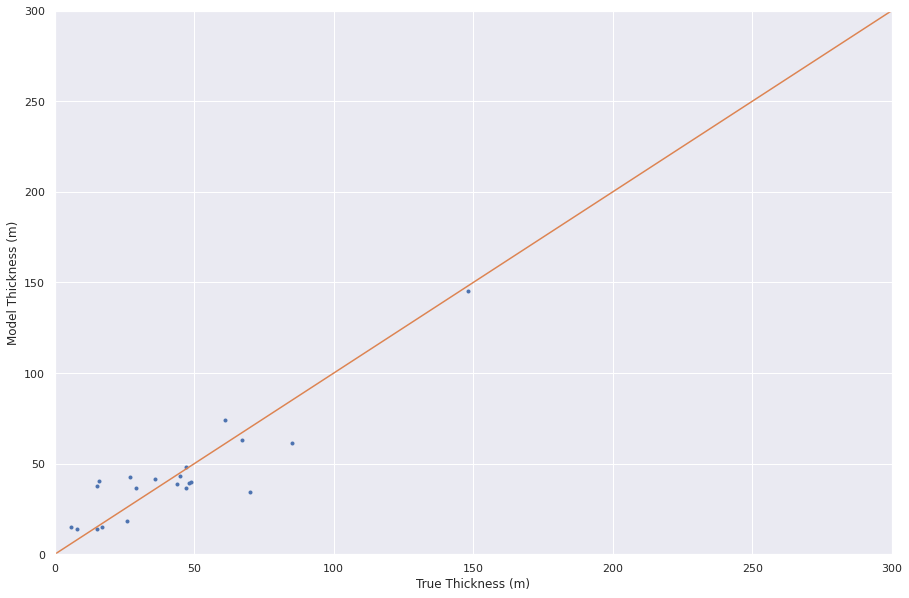

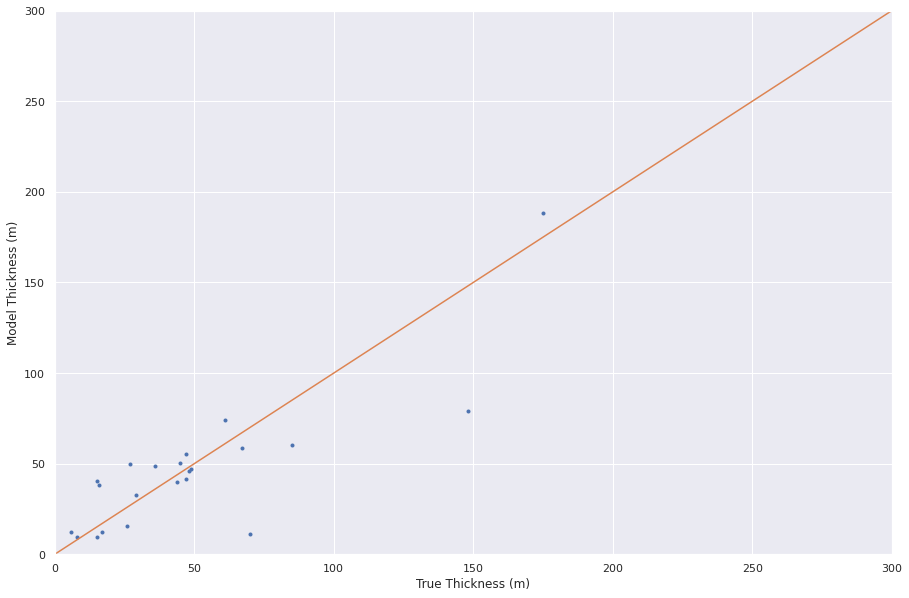

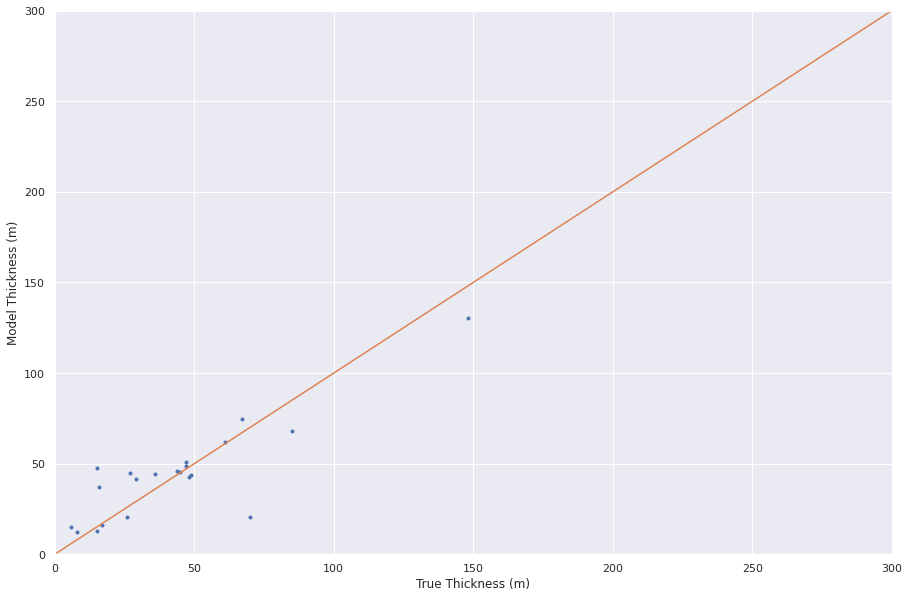

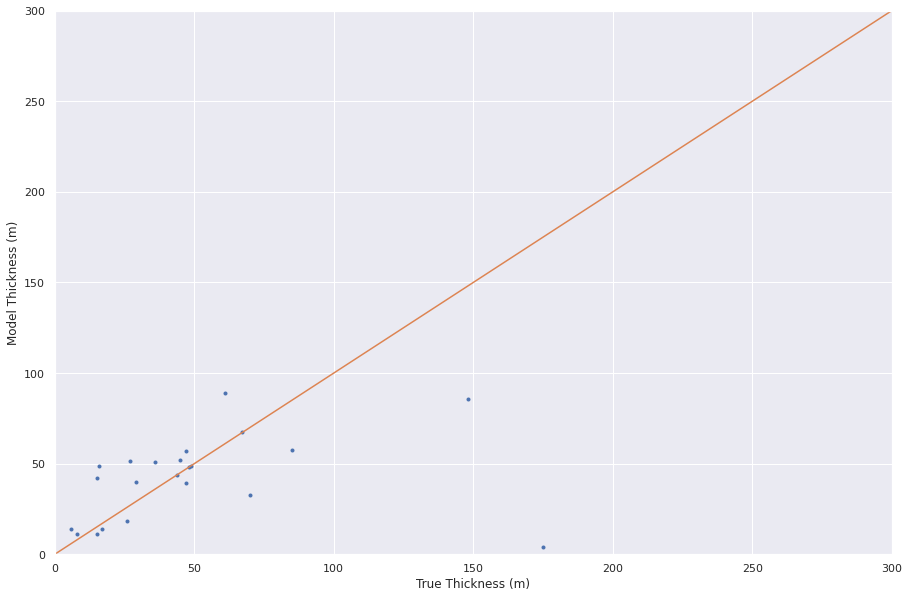

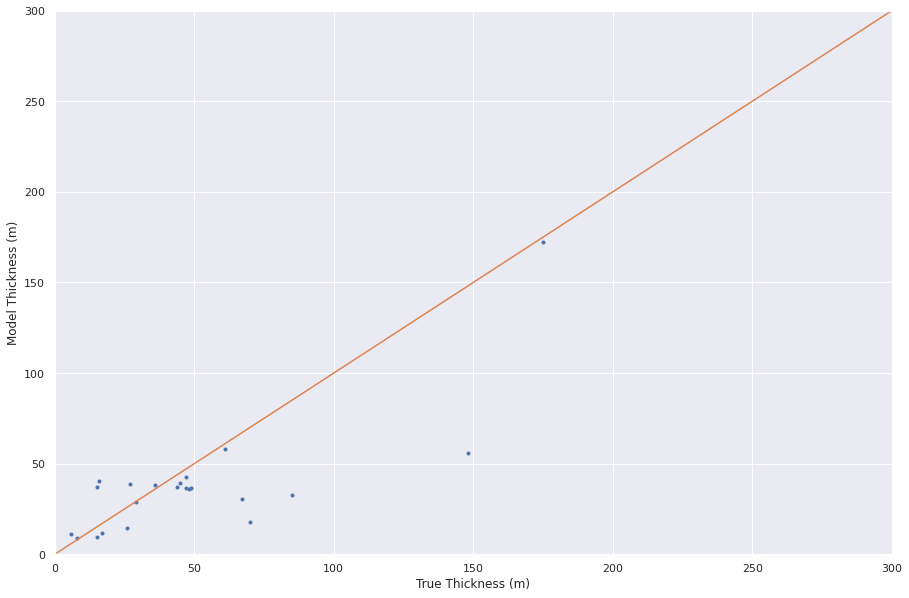

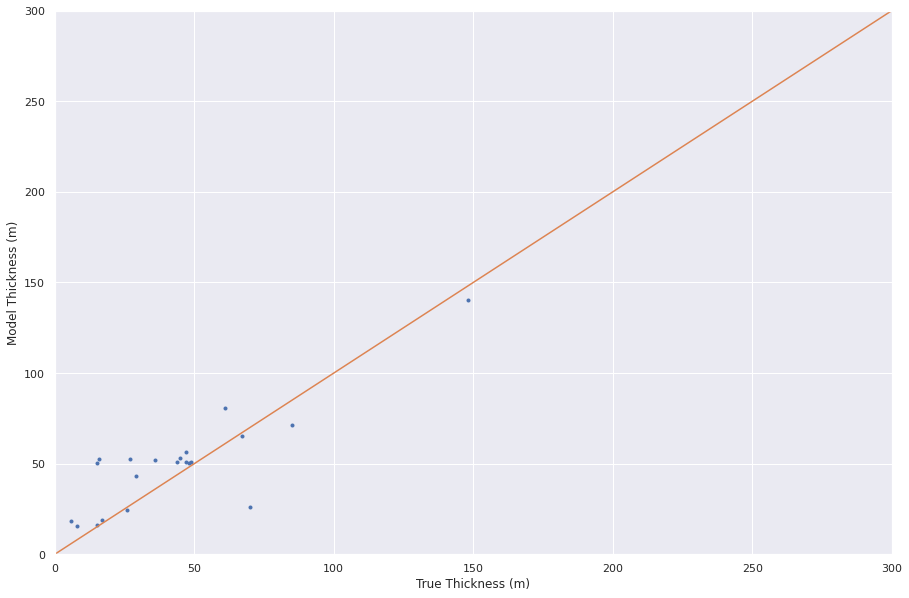

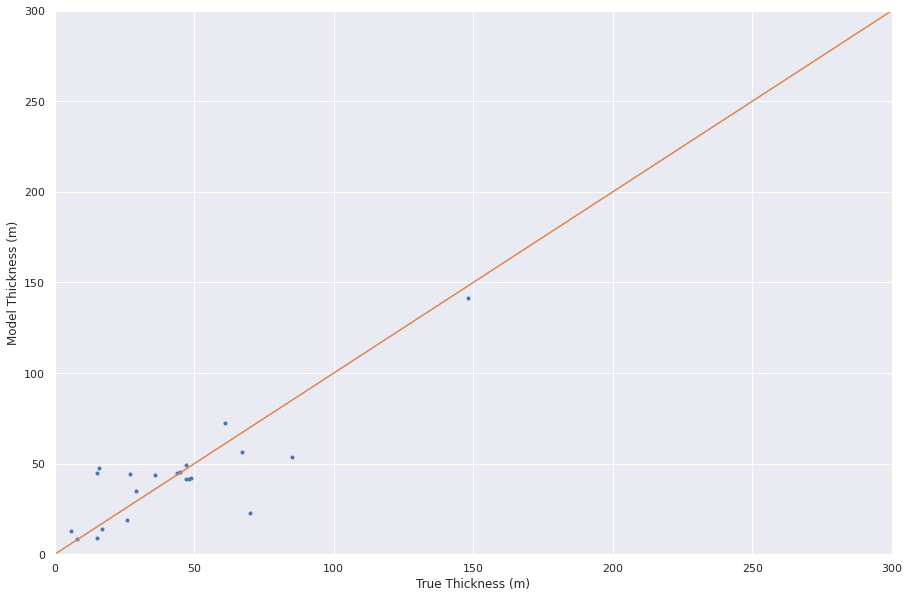

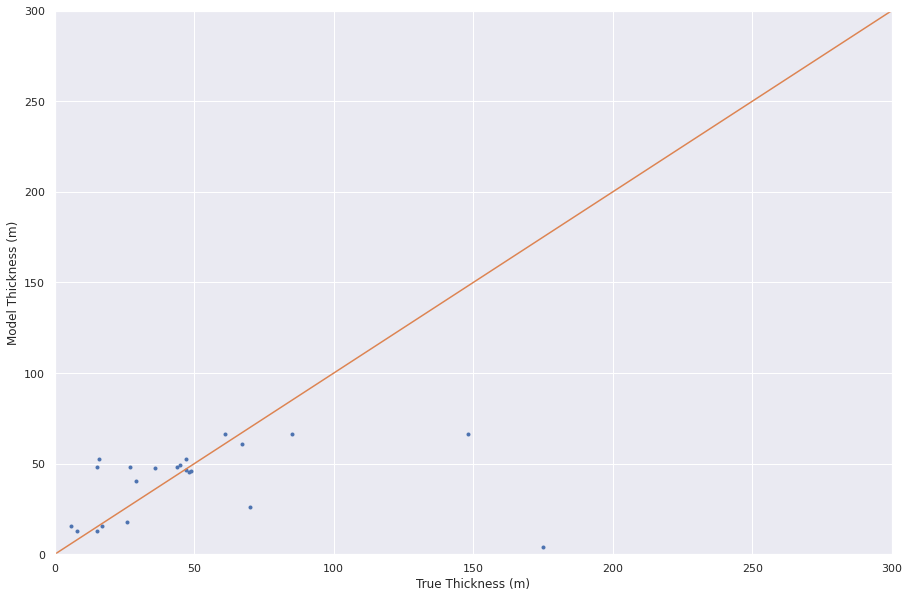

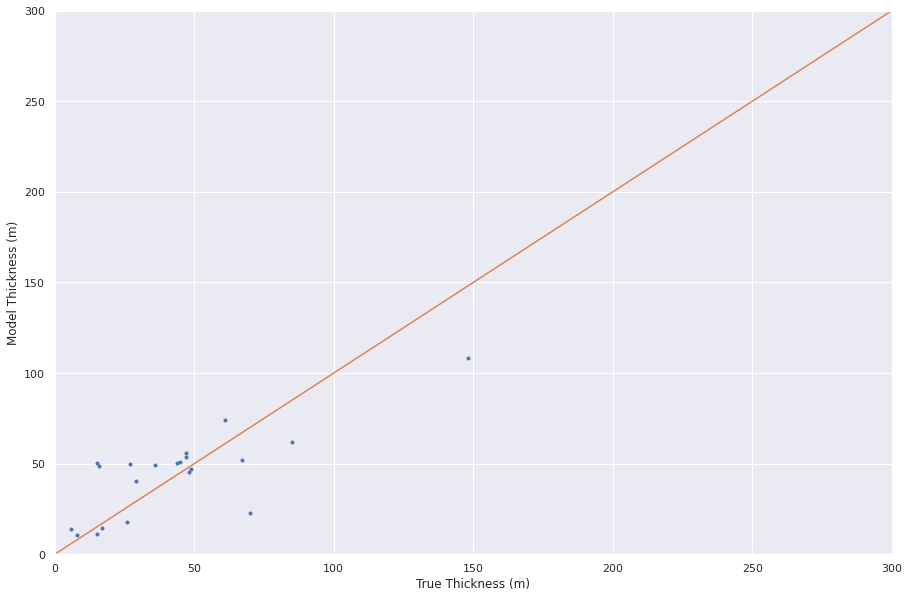

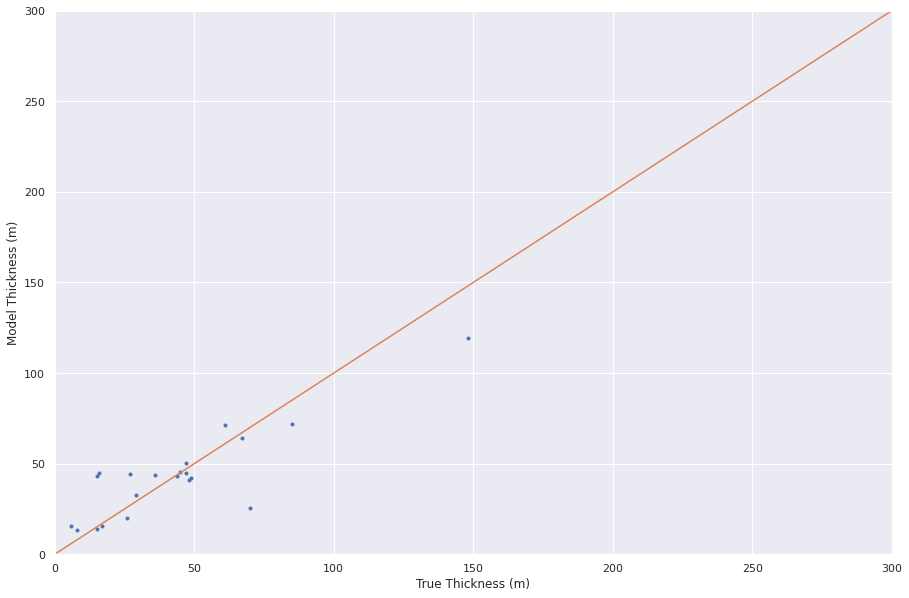

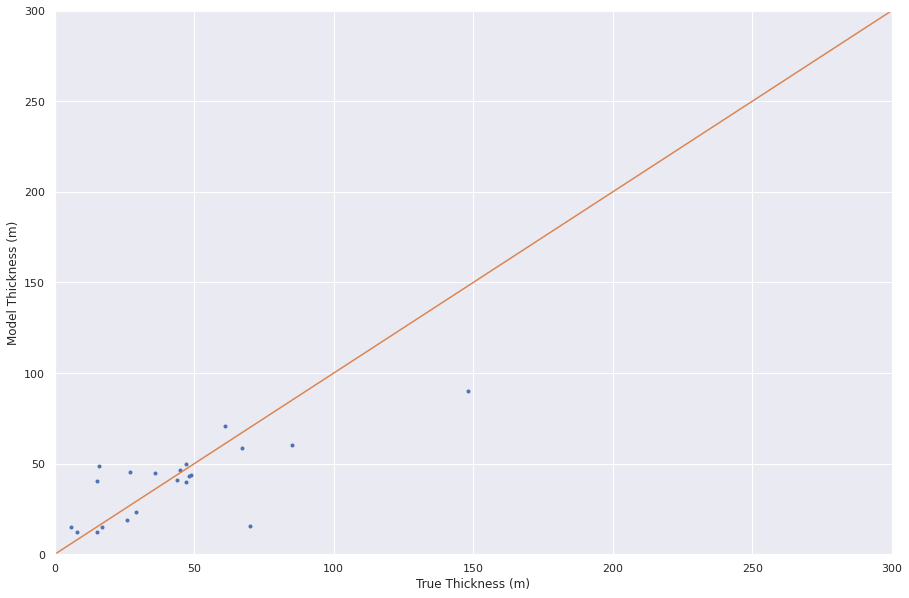

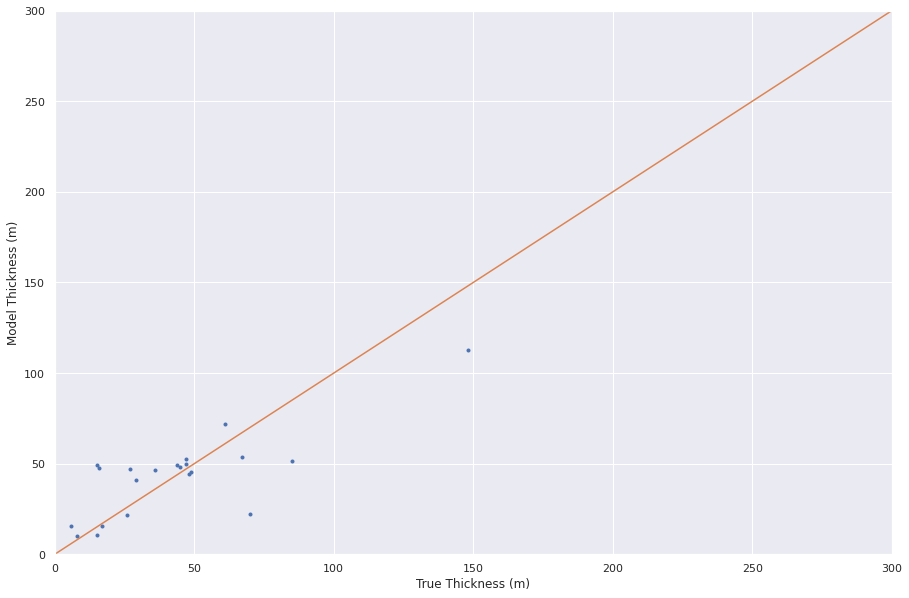

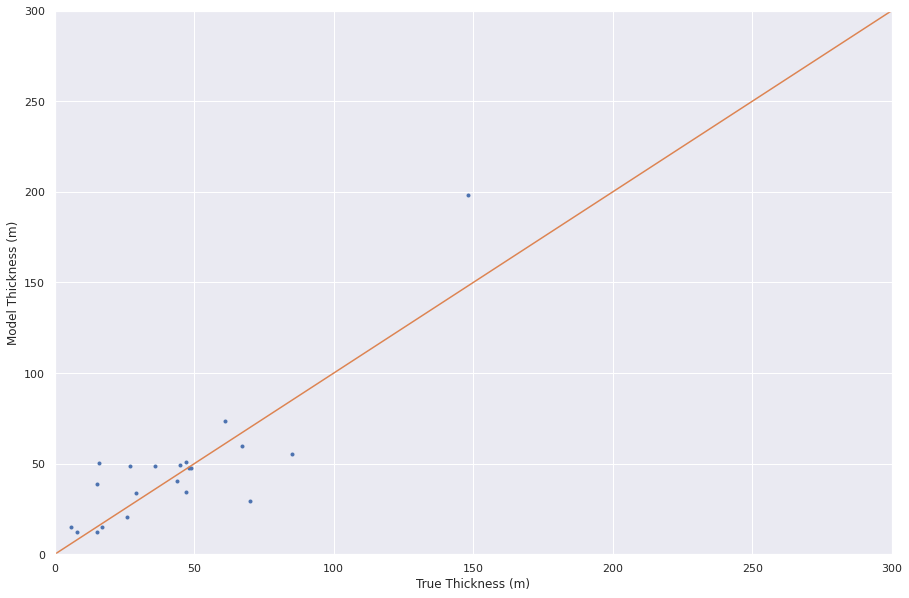

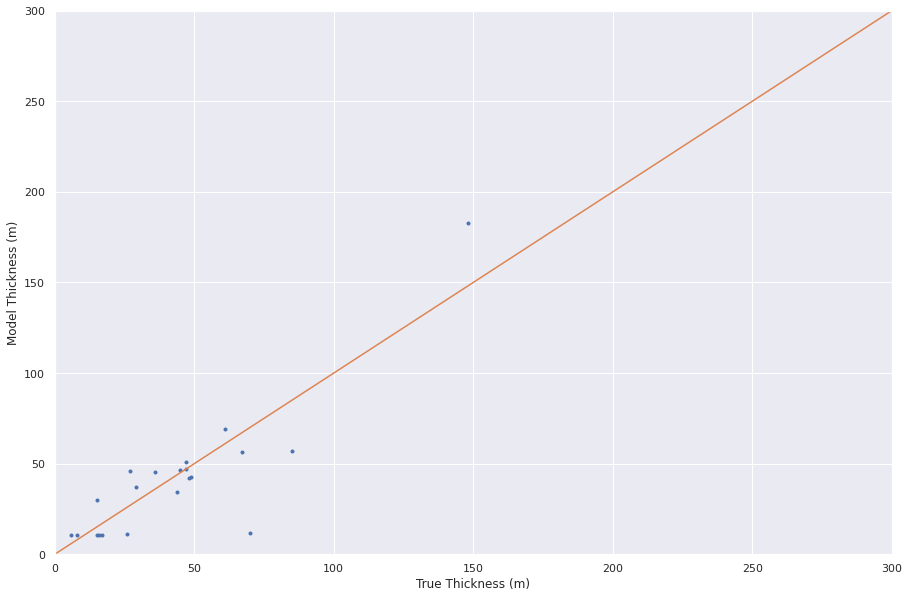

In [13]:
for rs in RS:    
    y = dnn_model['glacier_MULTI_0.1_0.2_300_' + str(rs)].predict(test_features)
    fig,ax=plt.subplots(1,1,figsize=(15,10))
    fig.patch.set_facecolor('w')
    plt.plot(test_labels,y,'.')
    plt.plot((0,300),(0,300),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    plt.xlim((0,300))
    plt.ylim((0,300))
    # plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T")

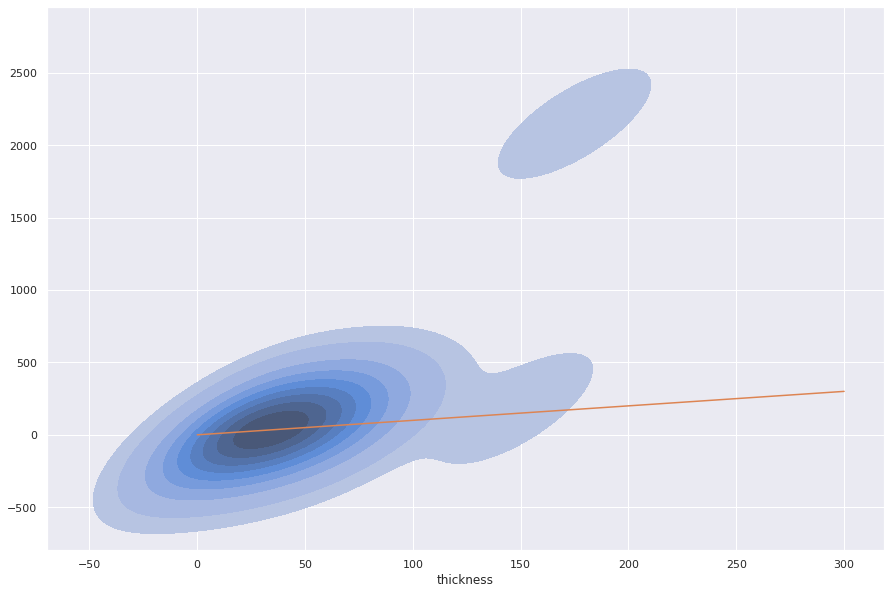

In [14]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

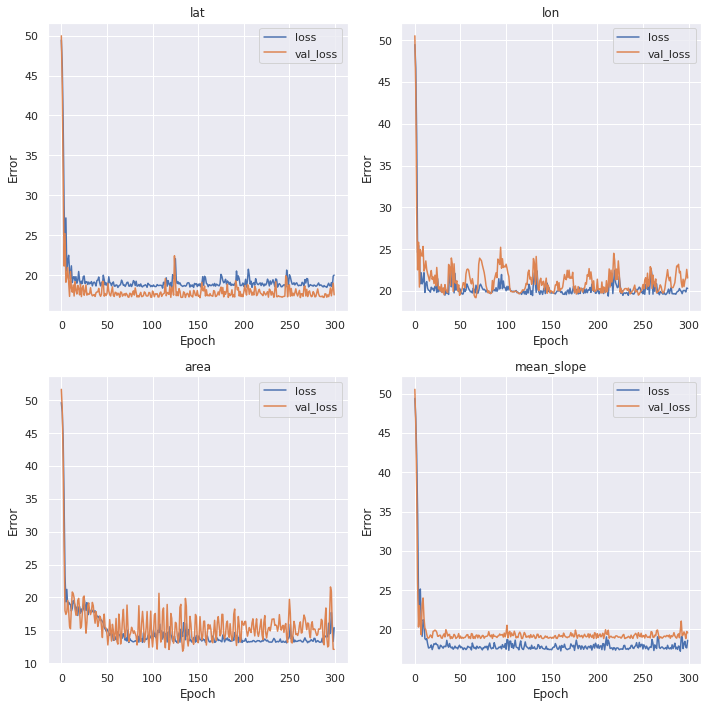

In [15]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# ax.set_ylim([5,30])

# gl.plot_loss(dnn_history['T_MULTI'])
for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['glacier_'+ variable_name+ '_0.1_0.2_300_6'])
#     ax.set_ylim([35,140])
    ax.set_title(variable_name)
    plt.tight_layout()
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")


/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


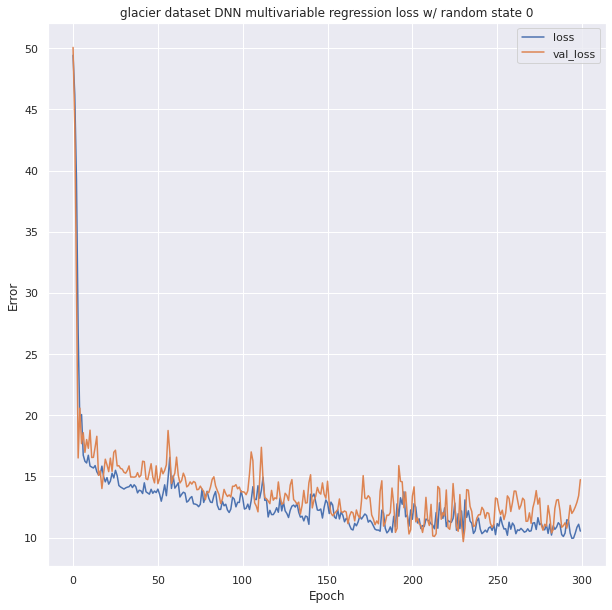

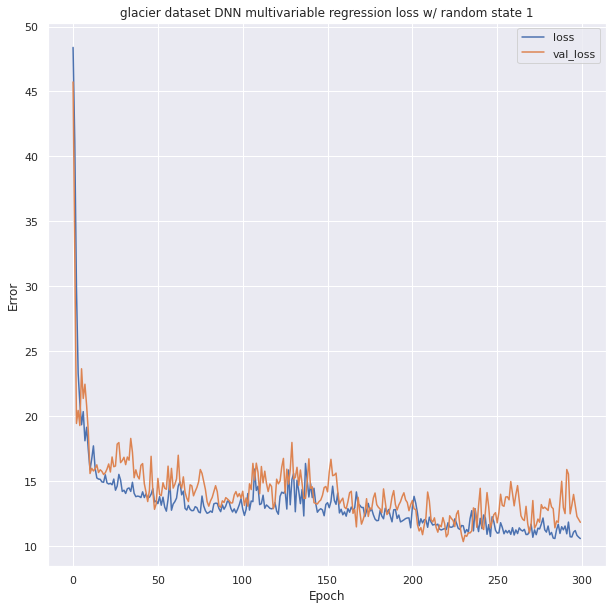

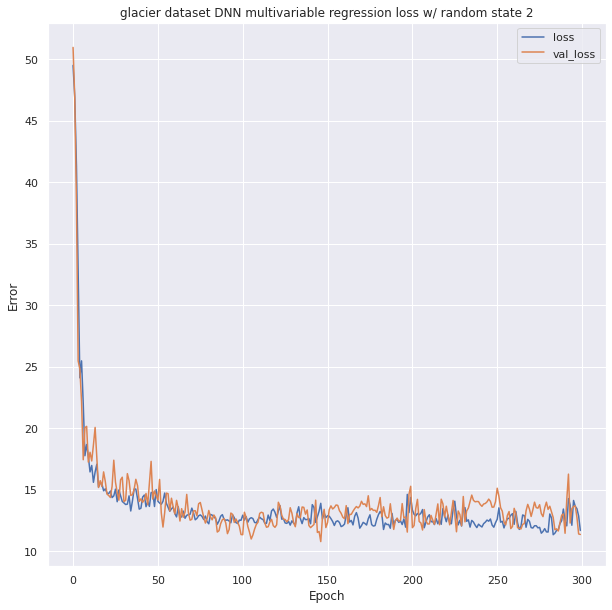

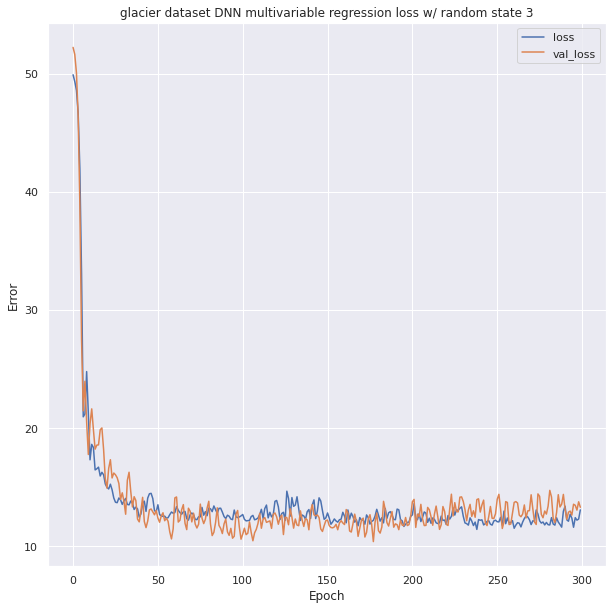

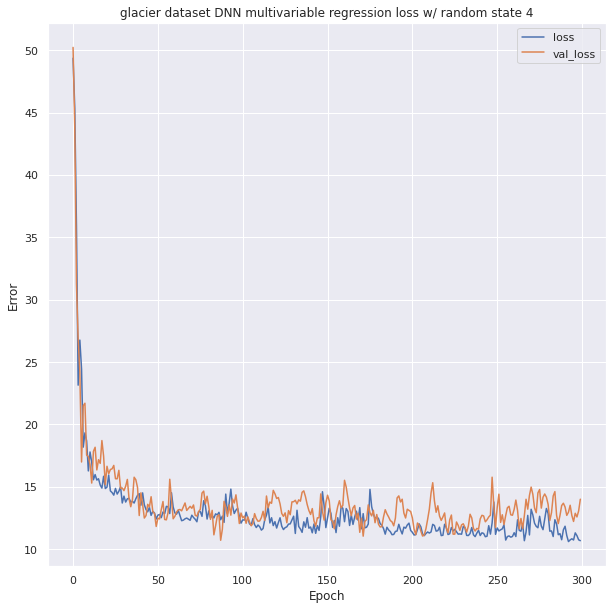

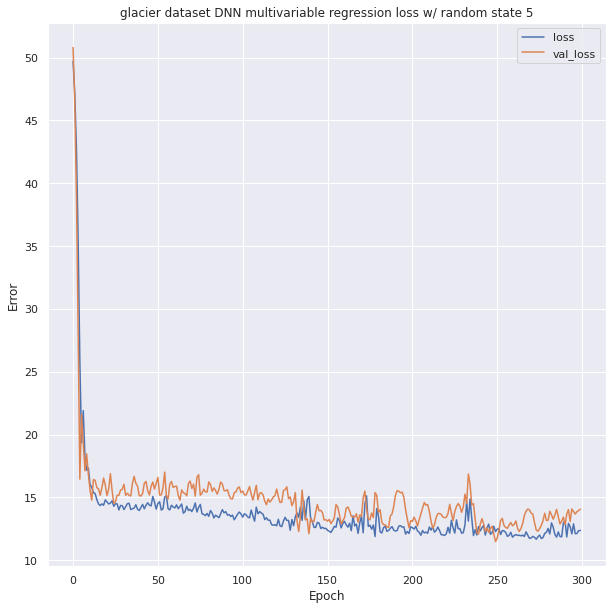

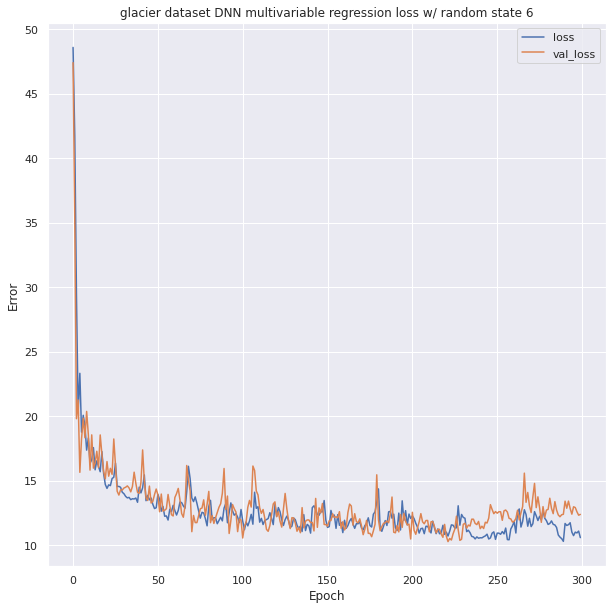

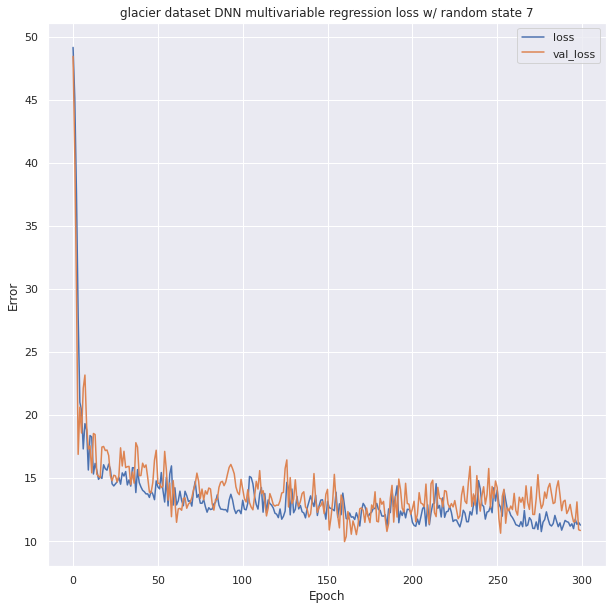

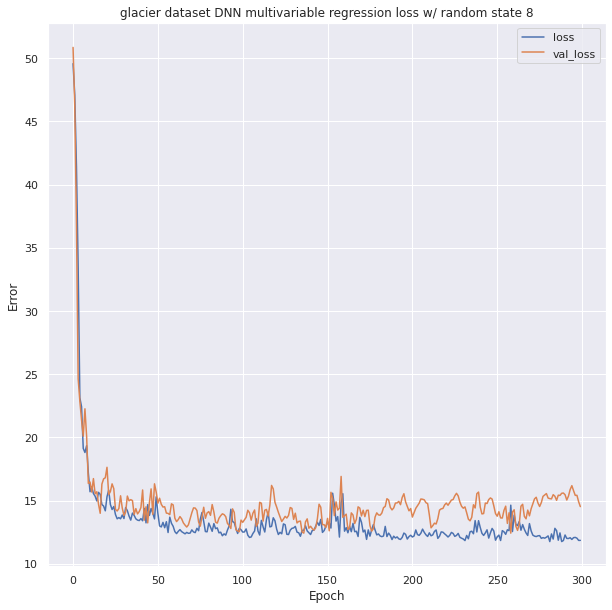

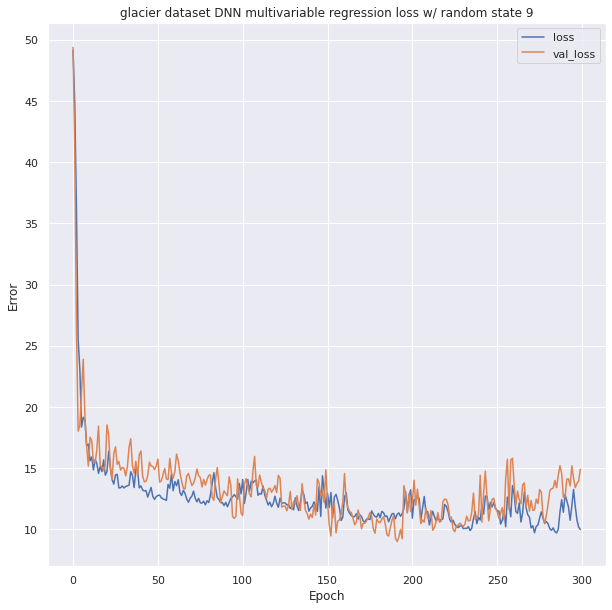

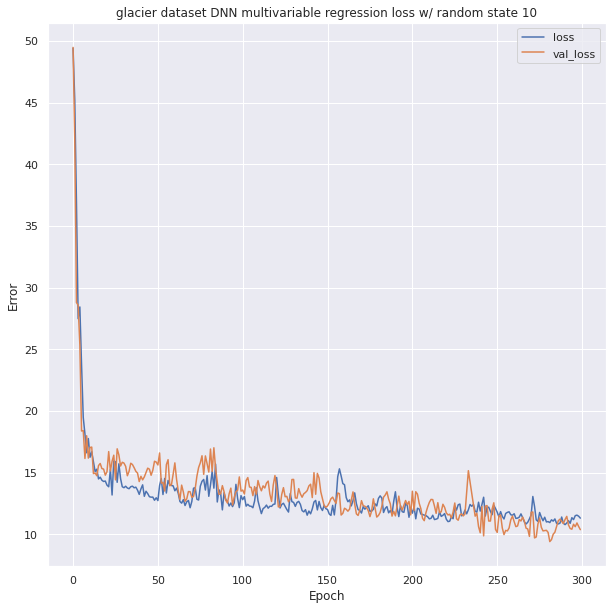

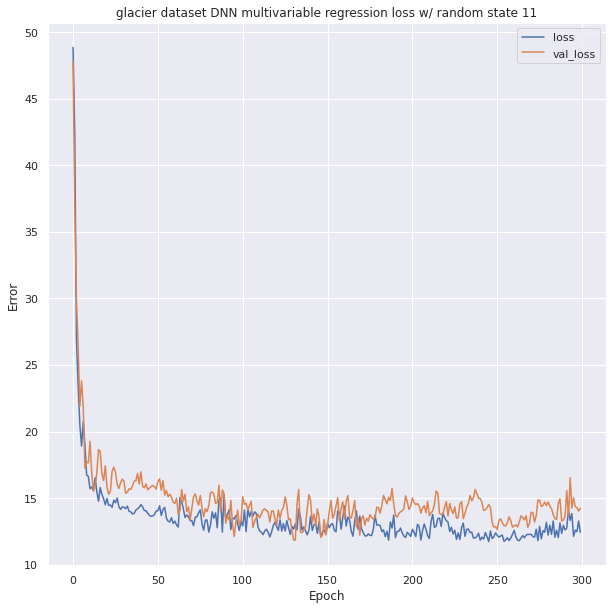

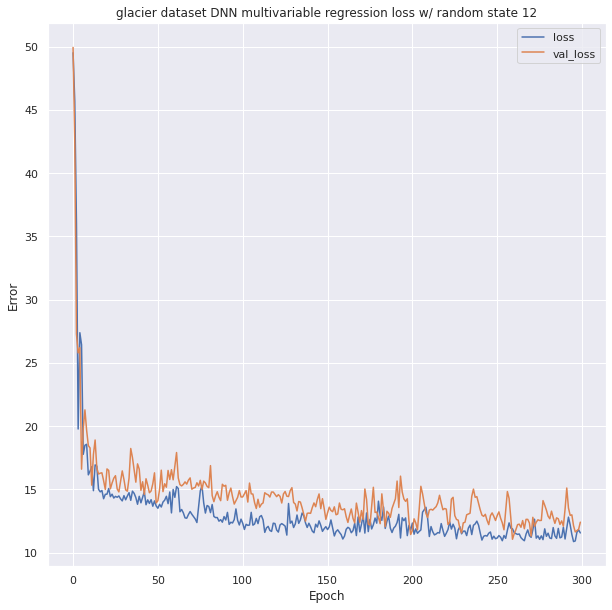

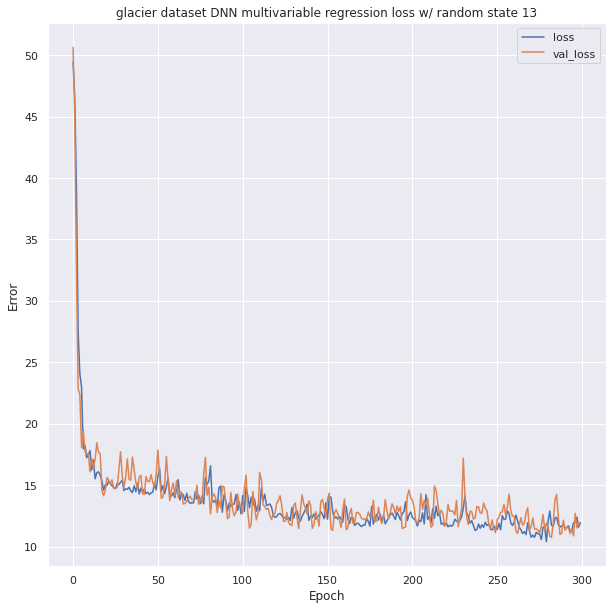

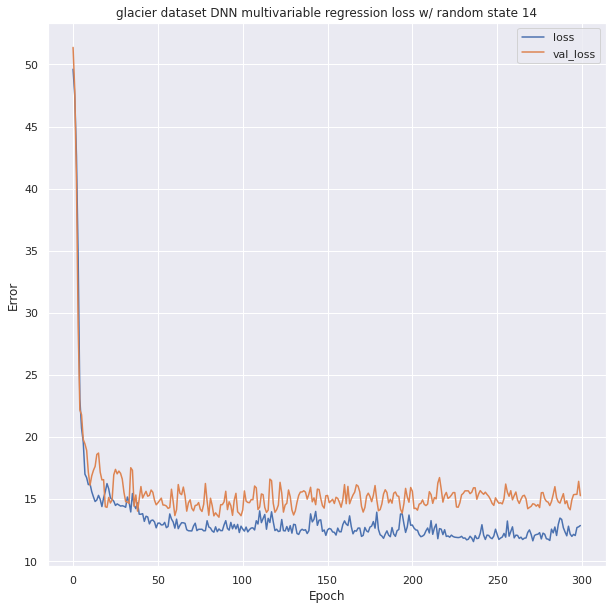

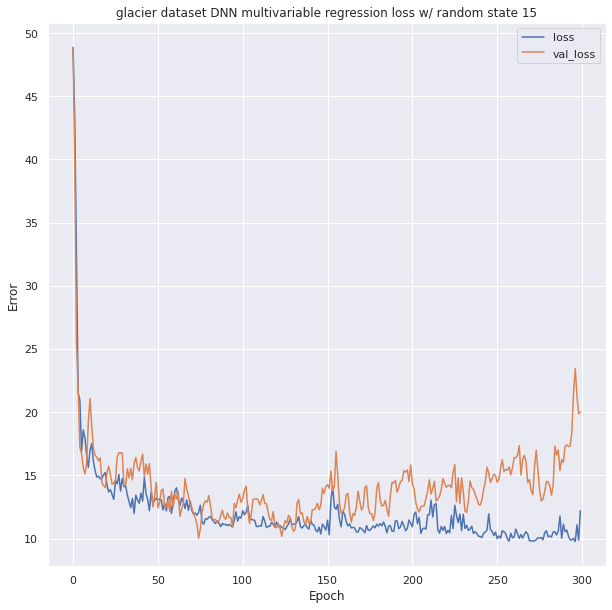

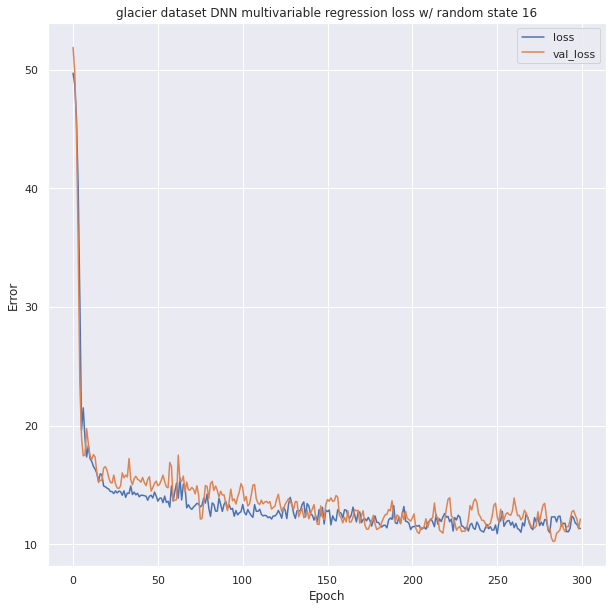

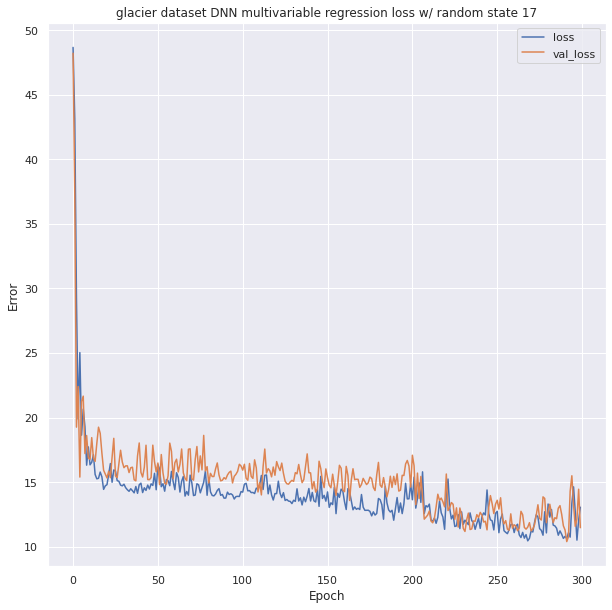

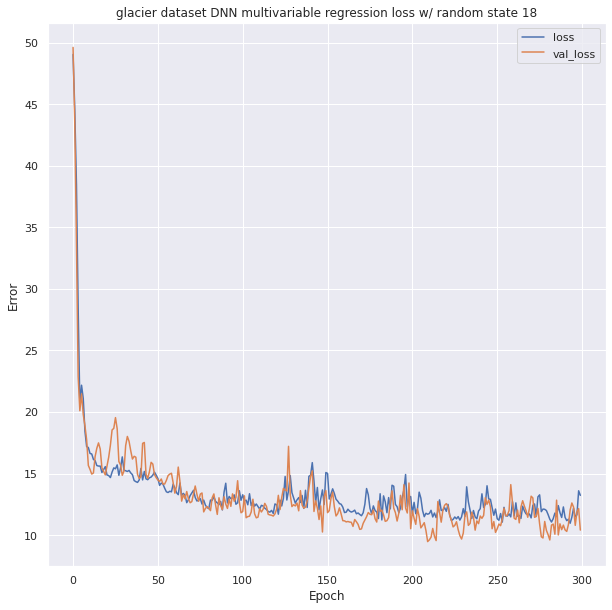

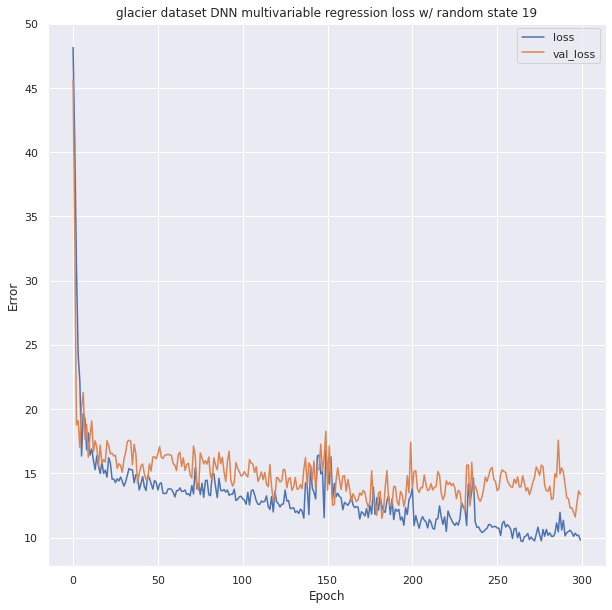

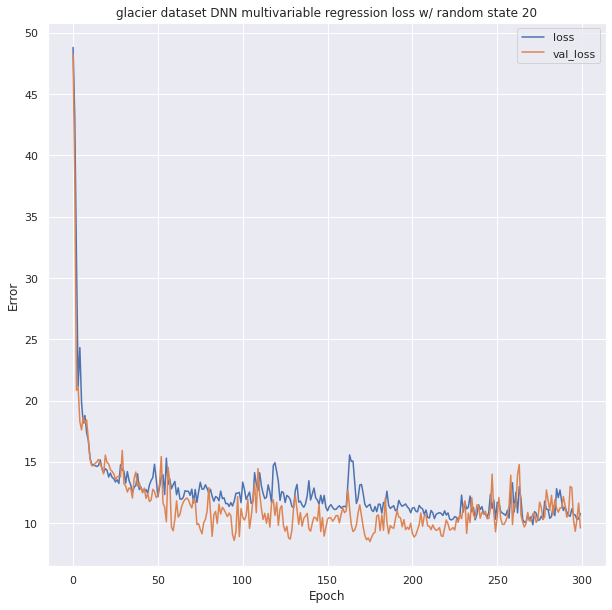

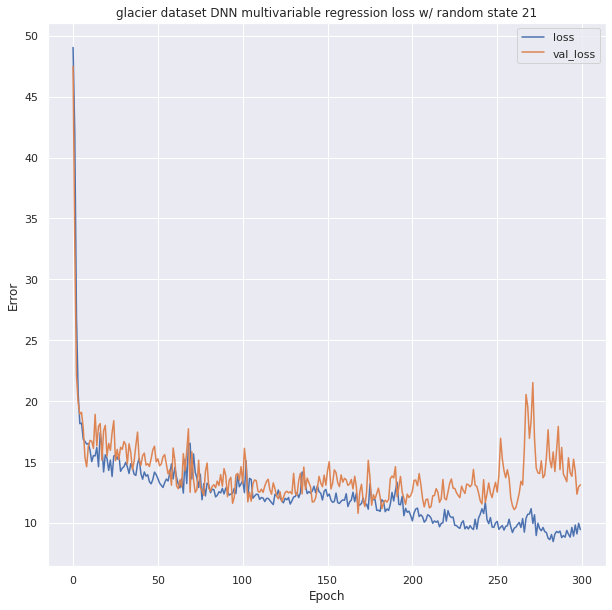

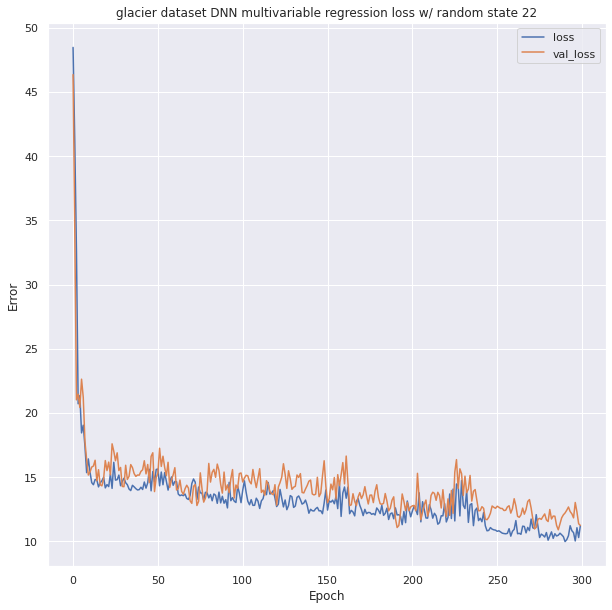

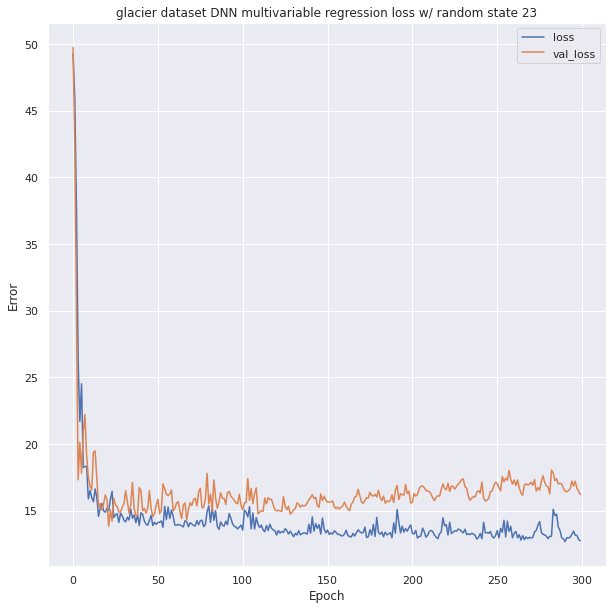

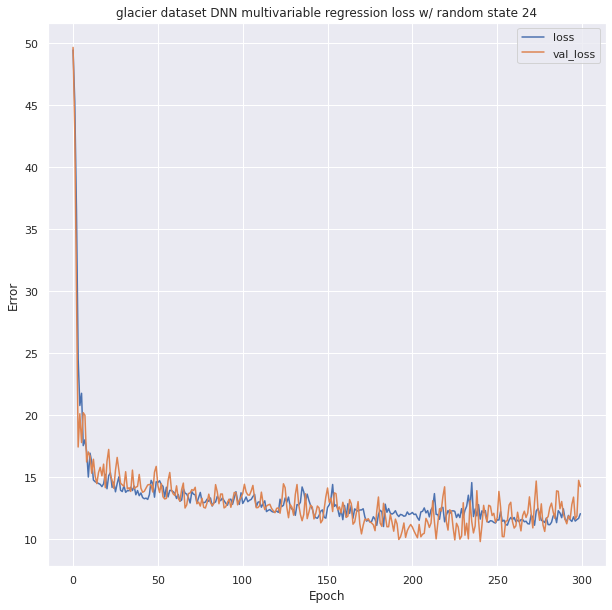

In [16]:
for rs in RS:    
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    fig.patch.set_facecolor('w')
    ax.set_title('glacier dataset DNN multivariable regression loss w/ random state ' + str(rs))
    gl.plot_loss(dnn_history['glacier_MULTI_0.1_0.2_300_' + str(rs)])
    # plt.savefig("/home/sa42/notebooks/glac/figs/GTP_dnn_loss.eps")

In [17]:
# def plot_single_variable(x,y,model_type,model_name,feature_name):
#     y = model_type[model_name].predict(test_labels)
#     plt.scatter(train_features[feature_name], train_labels, label='Data')
#     plt.plot(x, y,'.', color='k', label='Predictions')
#     plt.xlabel(feature_name)
#     plt.ylabel('THICKNESS')
#     plt.legend()
#     plt.plot()

# x = test_labels
# for i, variable_name in enumerate(list(train_features)):
#     ax = plt.subplot(2,2,i+1)
#     model_name = (dataset.name 
#     + '_' 
#     + variable_name 
#     + '_' 
#     + str(lr) 
#     + '_' 
#     + str(vs) 
#     + '_' 
#     + str(ep))
#     plot_single_variable(x,y,dnn_model, model_name,variable_name)
# #     ax.set_ylim([35,140])
# #     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
# plt.tight_layout()